In [1]:
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision.transforms as transform
from torchvision.datasets import ImageFolder

In [3]:
import tarfile

dataset_url = 'https://s3.amazonaws.com/fast-ai-imageclas/imagewoof-320.tgz'

datasets.utils.download_url(dataset_url, '.')

with tarfile.open('./imagewoof-320.tgz', 'r:gz') as tar:
  tar.extractall(path = './data')

In [4]:
data_dir = './data/imagewoof-320'

# get the name of all the directory in the data_dir
print(os.listdir(data_dir))

['train', 'val']


In [5]:
class_names = ['Australian terrier', 'Border terrier', 'Samoyed', 'Beagle', 'Shih-Tzu', 'English foxhound', 'Rhodesian ridgeback', 'Dingo', 'Golden retriever', 'Old English sheepdog']
len(class_names)

10

In [6]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler 

valid_size = 20 # valid size 20% if test data
batch_size = 64
num_workers= 0

train_directory = './data/imagewoof-320/train'
test_directory = './data/imagewoof-320/val'


# create train transform
train_transform = transform.Compose([transform.RandomCrop(160), 
                        transforms.Resize(size=160),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomVerticalFlip(),
                        transforms.RandomRotation(30),
                        transform.ToTensor(),
                        transform.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# create test transform
test_transform = transform.Compose([transform.RandomResizedCrop(160),
                        transform.ToTensor(), 
                        transform.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

train_data = ImageFolder(data_dir + '/train', train_transform)
test_data = ImageFolder(data_dir + '/val', test_transform)

print('  Number of train images: ', len(train_data))
print('  Number of test images:  ', len(test_data))

# split test into test and valid
num_train = len(train_data)
indicies = list(range(num_train))

np.random.shuffle(indicies)

split = int(np.floor(valid_size / 100 * num_train))

train_idx, valid_idx = indicies[split:], indicies[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# create data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)


print(train_loader)
print(valid_loader)
print(test_loader)

  Number of train images:  12454
  Number of test images:   500


In [7]:
print(train_data.classes)

['n02086240', 'n02087394', 'n02088364', 'n02089973', 'n02093754', 'n02096294', 'n02099601', 'n02105641', 'n02111889', 'n02115641']


In [8]:
classes_dict = dict(zip(train_data.classes, class_names))
classes_dict

{'n02086240': 'Australian terrier',
 'n02087394': 'Border terrier',
 'n02088364': 'Samoyed',
 'n02089973': 'Beagle',
 'n02093754': 'Shih-Tzu',
 'n02096294': 'English foxhound',
 'n02099601': 'Rhodesian ridgeback',
 'n02105641': 'Dingo',
 'n02111889': 'Golden retriever',
 'n02115641': 'Old English sheepdog'}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


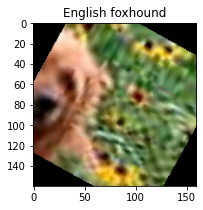

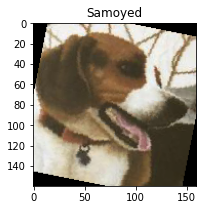

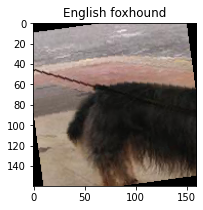

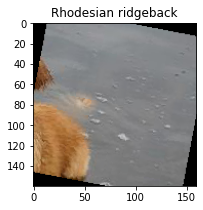

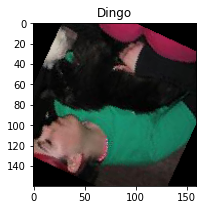

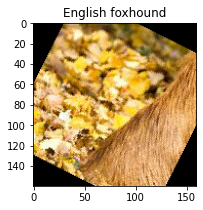

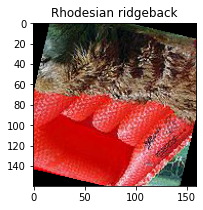

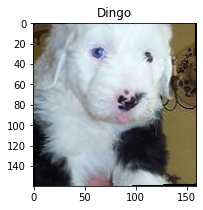

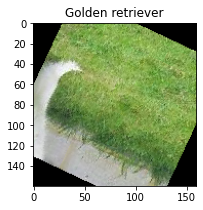

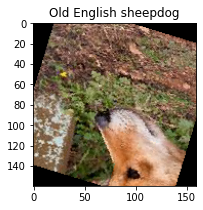

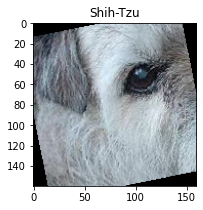

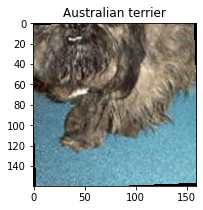

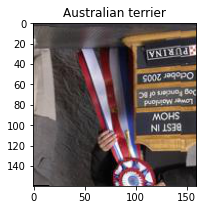

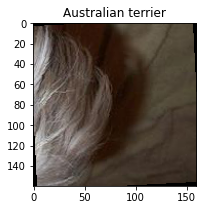

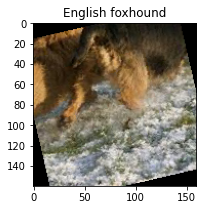

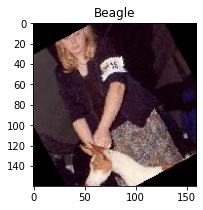

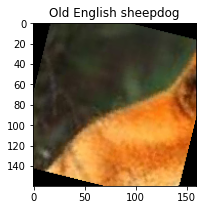

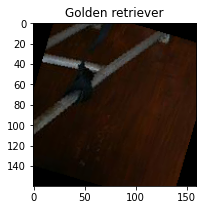

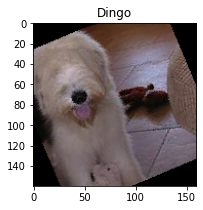

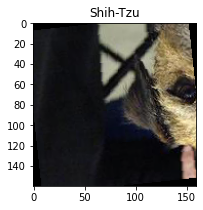

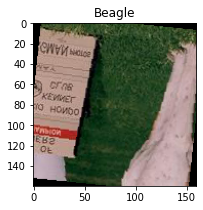

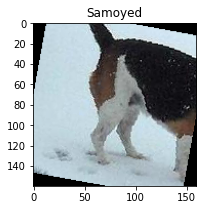

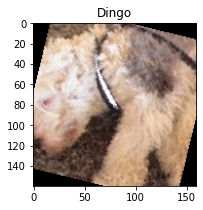

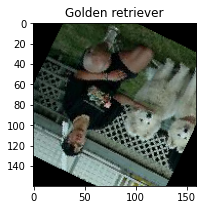

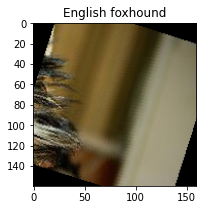

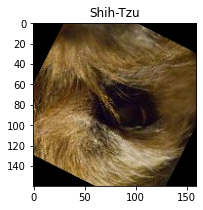

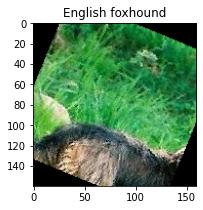

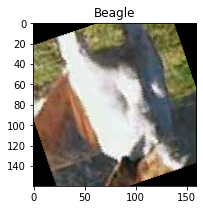

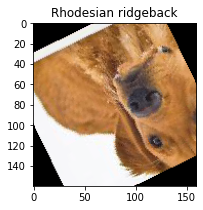

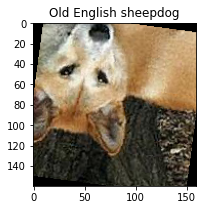

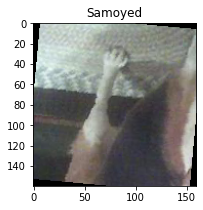

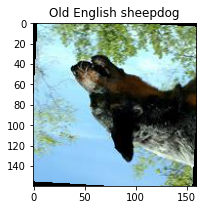

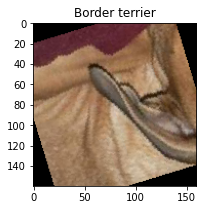

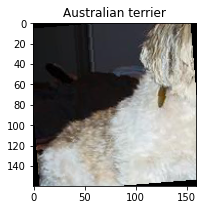

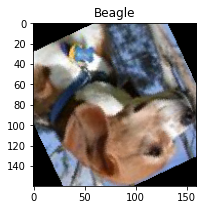

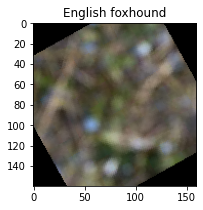

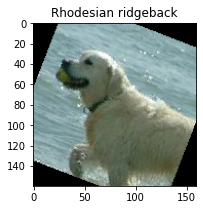

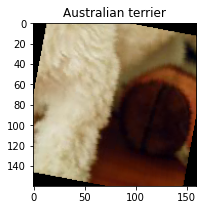

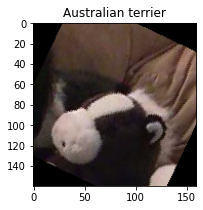

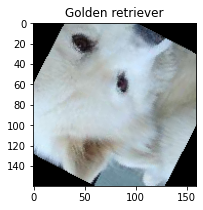

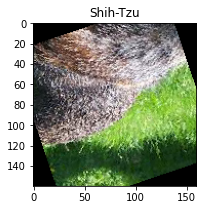

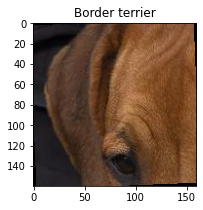

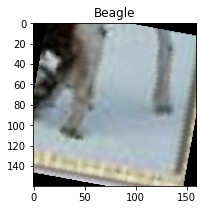

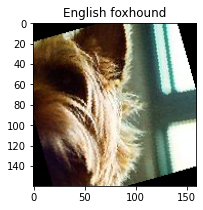

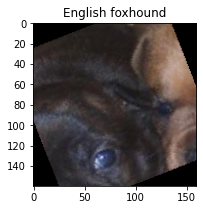

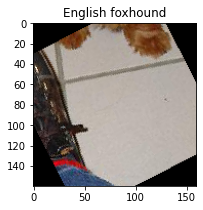

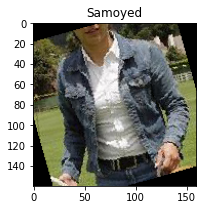

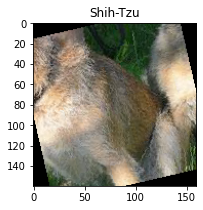

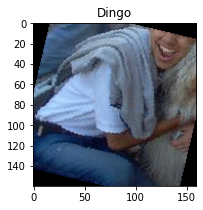

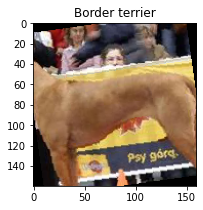

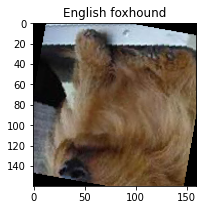

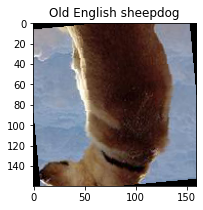

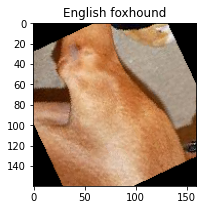

In [9]:
inputs, classes = iter(train_loader).next()

for image, label in zip(inputs, classes):
    image = image.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
     
    fig = plt.figure(figsize=(12,3))
    plt.imshow(image)
    plt.title(class_names[label.item()])

In [10]:
use_cuda = torch.cuda.is_available()

if use_cuda:
  print("training on cuda")
else:
  print("training on cpu")

training on cuda


In [11]:
ResNet50 = models.resnet50(pretrained=True)

## freeze weights in features layers only
for param in ResNet50.parameters():
    param.requires_grad = False
    
## change the last FCL in model
ResNet50.fc = nn.Linear(ResNet50.fc.in_features, 10)
print(ResNet50)


# move model to GPU if CUDA is available
if use_cuda:
    ResNet50 = ResNet50.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ResNet50.parameters(), lr=0.01)

In [13]:
def train(n_epochs, train_loader, valid_loader, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    if os.path.exists(save_path):
            print("load previous saved model ...")
            model.load_state_dict(torch.load(save_path))
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # clear the gradients
            optimizer.zero_grad()
            # forward pass
            output = model(data)
            # calculate loss
            loss = criterion(output, target)
            # backward pass
            loss.backward()
            # perfrom step operation to update values
            optimizer.step()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            train_loss += loss.item() * data.size(0)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            # calculate loss
            loss = criterion(output, target)
            
            valid_loss += loss.item() * data.size(0)
            
        train_loss = train_loss / len(train_loader.dataset)
        valid_loss = valid_loss / len(valid_loader.dataset)

        
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ), end="")
        
        if(valid_loss <= valid_loss_min):
            print('  Saving model ...')
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)
        else:
            print("")
    # return trained model
    return model

In [15]:
ResNet50 = train(5, train_loader, valid_loader, ResNet50, optimizer, criterion, use_cuda, 'res_net_50.pt')

load previous saved model ...
Epoch: 1 	Training Loss: 0.743985 	Validation Loss: 0.197661  Saving model ...
Epoch: 2 	Training Loss: 0.751315 	Validation Loss: 0.195532  Saving model ...
Epoch: 3 	Training Loss: 0.748449 	Validation Loss: 0.194781  Saving model ...
Epoch: 4 	Training Loss: 0.748759 	Validation Loss: 0.187179  Saving model ...
Epoch: 5 	Training Loss: 0.743967 	Validation Loss: 0.191789


In [16]:
def test(data_loader, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(data_loader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [17]:
ResNet50.load_state_dict(torch.load('res_net_50.pt'))

<All keys matched successfully>

In [18]:
test(test_loader, ResNet50, criterion, use_cuda)

Test Loss: 0.545185


Test Accuracy: 81% (405/500)
